# 基于机器学习模型二次融合的单车使用量回归分析

- kaggle地址：https://www.kaggle.com/c/bike-sharing-demand

- 我的cpu是英特尔第 12 代酷睿 i9-12900KF 处理器，这段代码基本只用到cpu，为了方便大家跑代码，我下述代码中所有的线程都设置为1，避免出现内存溢出

- 代码时长运行超过1min的我都标注出来了

- 实测阿里云魔塔社区的免费CPU比我的电脑快得多


# 数据预处理

## 导入相关包

逻辑上肯定是用的时候在调用，之所以很多时候会看到别人的代码先导入是因为它运行完后手动调整了代码让代码更加美观

In [23]:
# pdpbox这个库要求matplotlib的版本必须是2.1.2，所以和其他库冲突，我们强制安装，实测不影响代码运行
#!pip install --upgrade --force-reinstall --no-deps pdpbox==0.2.1

In [24]:
# 数据处理
import numpy as np
import pandas as pd 
import calendar
from datetime import datetime
from scipy import stats
from scipy.stats import norm

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns 

# 模型
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 杂项
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


## 认识数据

In [25]:
# 这里我是用相对路径来读的，方便你直接运行，但是如果你移动了文件夹位置，这里可能会报错
data = pd.read_csv("./data/data.csv", parse_dates=True)  # parse_dates将csv中的时间字符串转换成日期格式
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-1-1 0:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-1-1 1:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-1-1 2:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-1-1 3:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-1-1 4:00,1,0,0,1,9.84,14.395,75,0.0,1


In [26]:
print(f"数据的形状是{data.shape}")

数据的形状是(10886, 10)


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB



### 数据集概览
- **数据集大小**: 10,886 行
- **列数**: 12 列
- **索引范围**: 0 到 10,885

### 数据列信息

| 列名         | 非空值数量 | 数据类型   | 描述                                                                 |
|--------------|------------|------------|----------------------------------------------------------------------|
| `datetime`   | 10,886     | `object`   | 日期和时间戳（每小时）                                               |
| `season`     | 10,886     | `int64`    | 季节：1 = 春季, 2 = 夏季, 3 = 秋季, 4 = 冬季                          |
| `holiday`    | 10,886     | `int64`    | 是否为假日（1 = 是, 0 = 否）                                          |
| `workingday` | 10,886     | `int64`    | 是否为工作日（既不是周末也不是假日，1 = 是, 0 = 否）                  |
| `weather`    | 10,886     | `int64`    | 天气状况：<br>1: 晴天, 少云, 部分多云<br>2: 雾 + 多云, 雾 + 碎云, 雾 + 少云<br>3: 小雪, 小雨 + 雷阵雨 + 散云, 小雨 + 散云<br>4: 大雨 + 冰雹 + 雷阵雨 + 雾, 雪 + 雾 |
| `temp`       | 10,886     | `float64`  | 温度（摄氏度）                                                       |
| `atemp`      | 10,886     | `float64`  | 体感温度（摄氏度）                                                   |
| `humidity`   | 10,886     | `int64`    | 相对湿度                                                             |
| `windspeed`  | 10,886     | `float64`  | 风速                                                                
| `count`      | 10,886     | `int64`    | 总租赁次数                                                           |




- **内存占用**: 1020.7+ KB

## 特征工程

对日期数据进行处理，提取时间相关信息，是一个比较简单的特征工程

In [28]:
# 日期数据处理
format = '%Y-%m-%d %H:%M'  # 调整格式字符串
data['date'] = pd.to_datetime(data['datetime'], format=format)
data['month'] = data.date.dt.month
data['day'] = data.date.dt.day
data['weekday'] = data.date.dt.weekday
data['hour'] = data.date.dt.hour
# 删除不需要的列
data.drop(['date'], axis=1, inplace=True)
data.drop(['datetime'], axis=1, inplace=True)

In [29]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,weekday,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,1,5,4


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   month       10886 non-null  int32  
 10  day         10886 non-null  int32  
 11  weekday     10886 non-null  int32  
 12  hour        10886 non-null  int32  
dtypes: float64(3), int32(4), int64(6)
memory usage: 935.6 KB


## 描述性统计

### 观察每个离散特征对于标签的影响

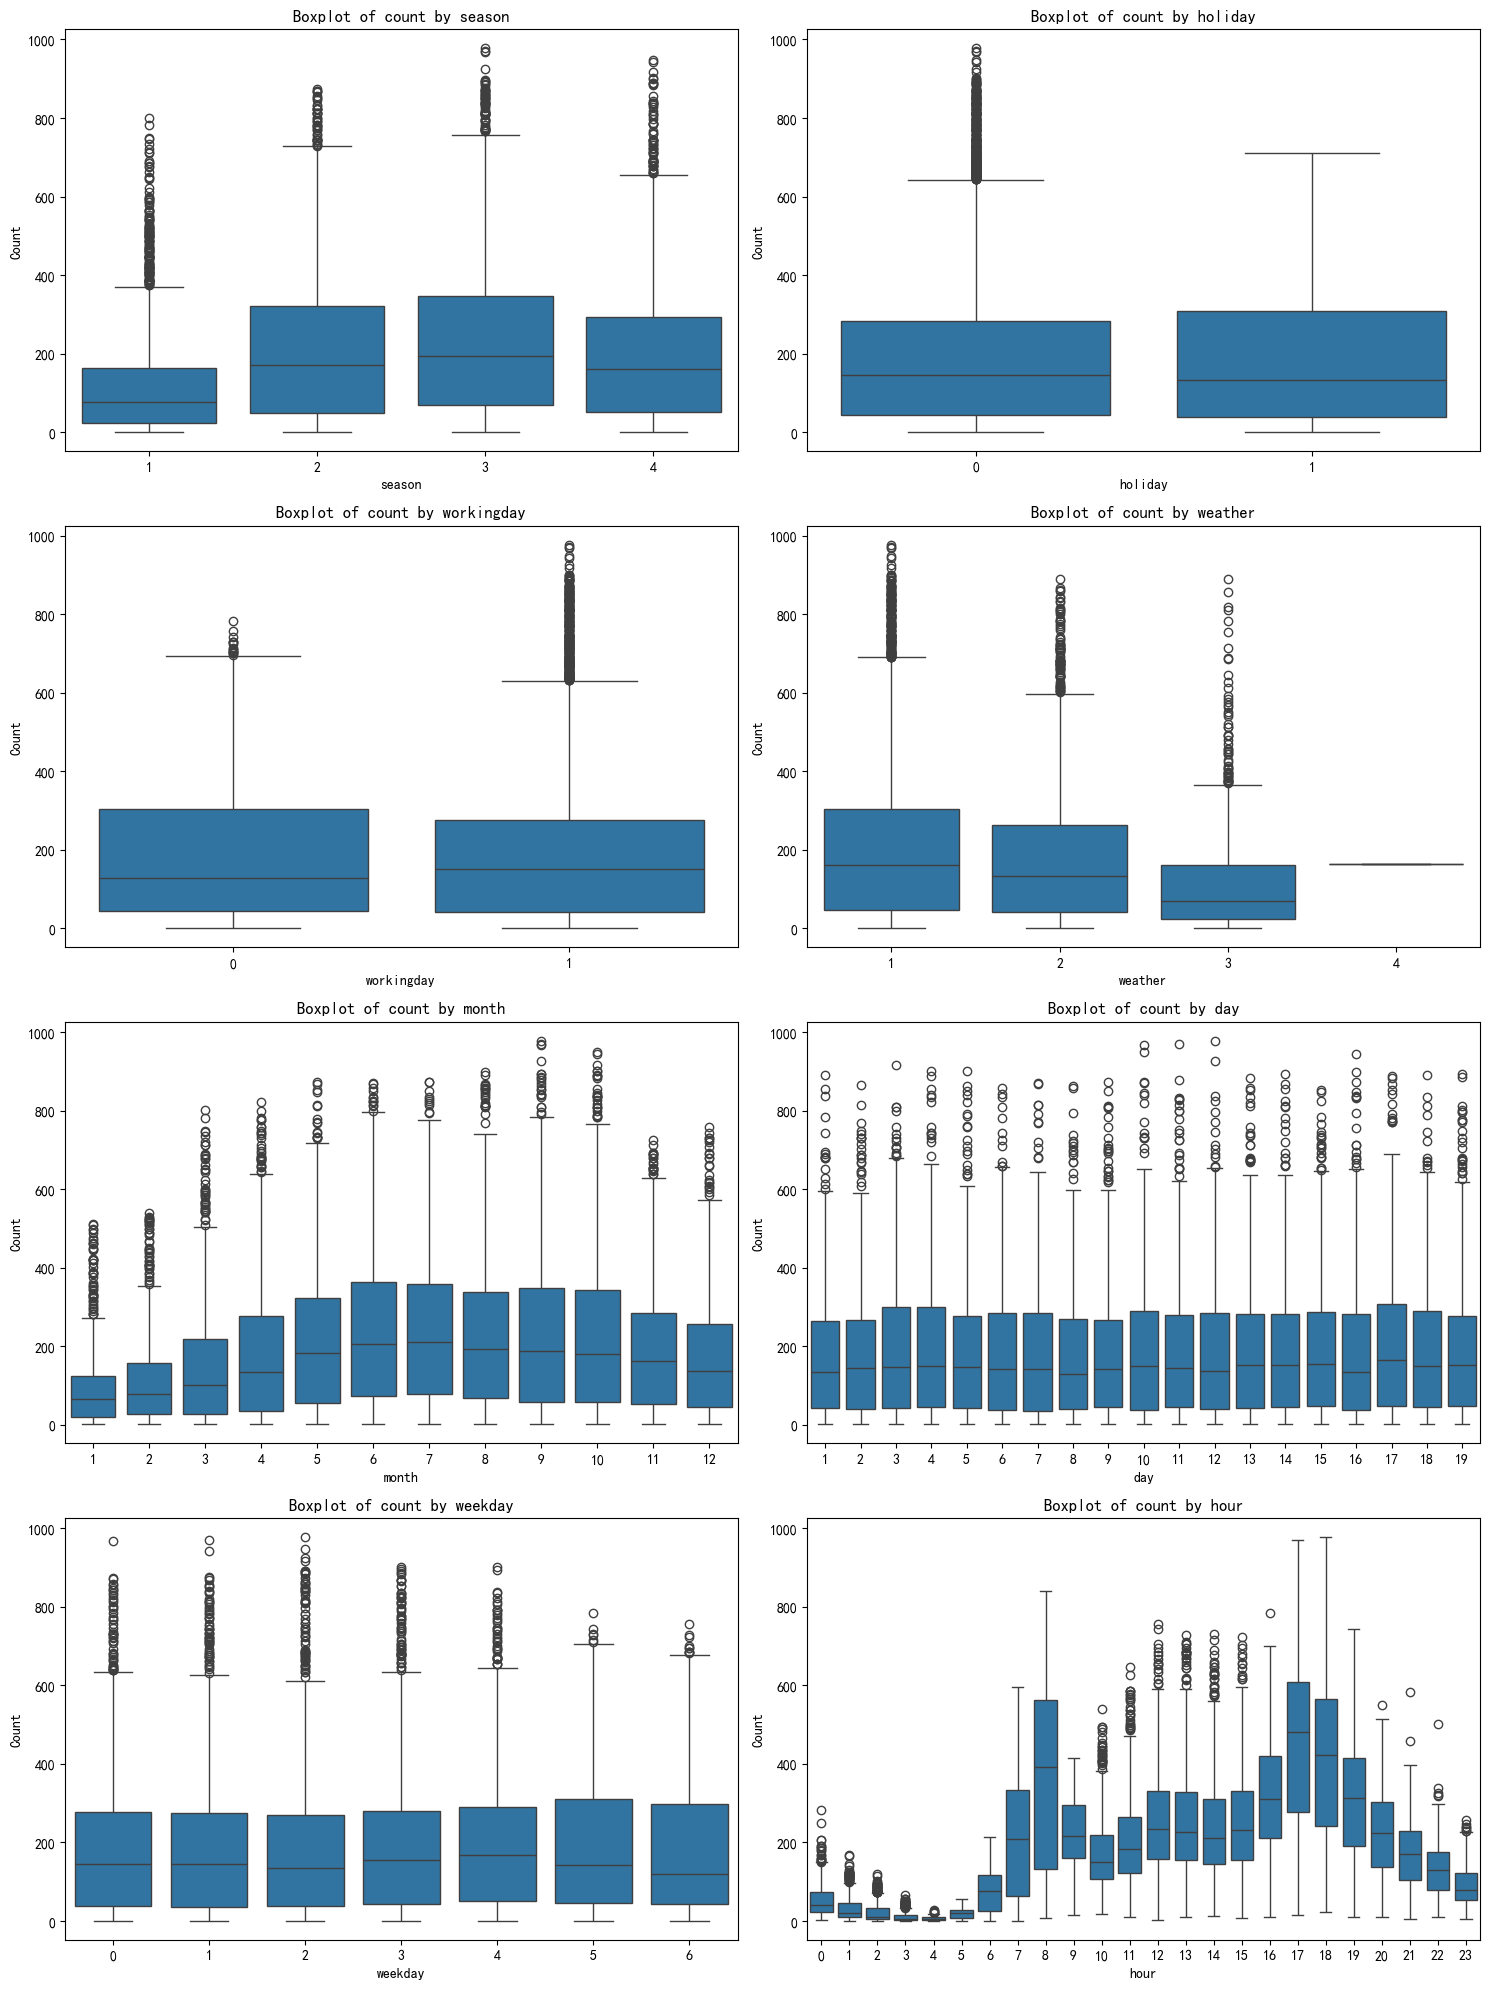

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# 定义离散变量列表
discrete_vars = ['season', 'holiday', 'workingday', 'weather', 'month', 'day', 'weekday', 'hour']

# 创建子图布局
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

# 遍历离散变量并绘制箱线图
for i, var in enumerate(discrete_vars):
    sns.boxplot(data=data, x=var, y='count', ax=axes[i])
    axes[i].set_title(f'Boxplot of count by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

# 调整子图布局
plt.tight_layout()
plt.show()

### 观察连续特征对于标签的影响

<Axes: >

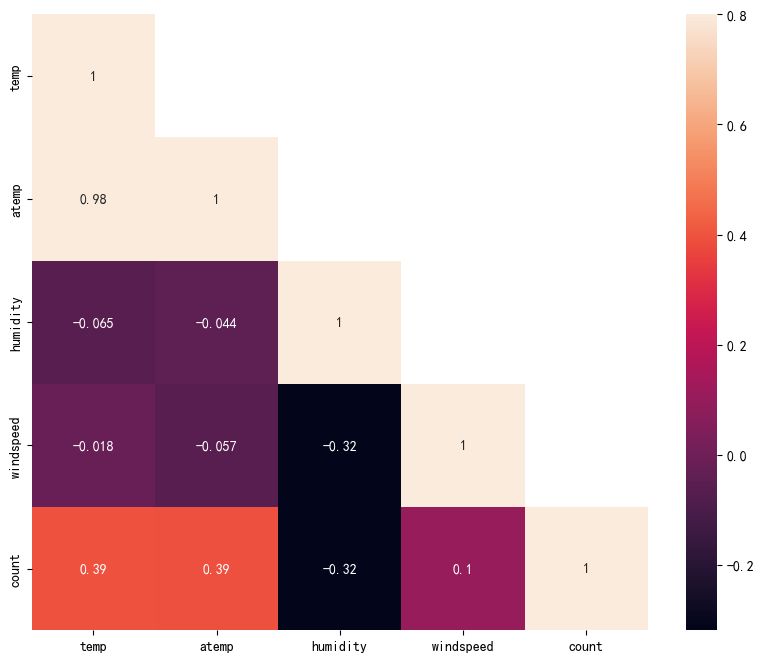

In [32]:
# 绘制原始数据的热力图，查看特征之间的相关性
corr_df = data[["temp", "atemp", "humidity", "windspeed", "count"]].corr()
mask = np.array(corr_df)
mask[np.tril_indices_from(mask)] = False  # mask = np.zeros_like(corr) # mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, mask=mask, vmax=0.8, square=True, annot=True)

temp 和 atemp 之间有很强的相关性，都纳入模型的话会造成多重共线性问题，所以必须删除其中一个特征。我们删除 atemp 特征，因为它与 count之间的相关性较 temp 弱。


In [33]:
data=data.drop(['atemp'],axis=1)
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,month,day,weekday,hour
0,1,0,0,1,9.84,81,0.0,16,1,1,5,0
1,1,0,0,1,9.02,80,0.0,40,1,1,5,1
2,1,0,0,1,9.02,80,0.0,32,1,1,5,2
3,1,0,0,1,9.84,75,0.0,13,1,1,5,3
4,1,0,0,1,9.84,75,0.0,1,1,1,5,4


## 划分数据

In [34]:
# 分离特征数据和标签数据
X = data.drop(['count'], axis=1)  # 特征数据
y = data['count']  # 标签数据

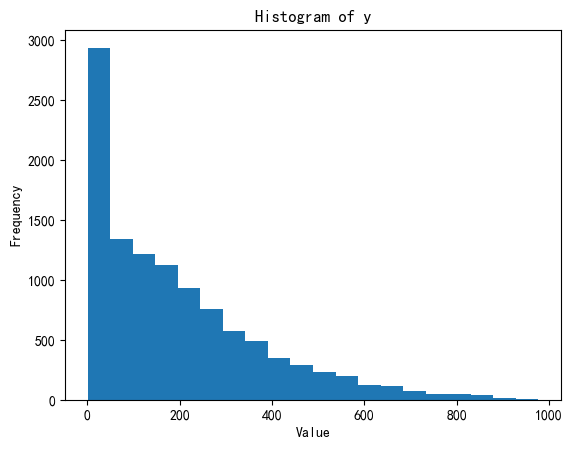

In [35]:
import matplotlib.pyplot as plt

# 假设 y = data['count'] 已经定义
# 绘制直方图
plt.hist(y, bins=20)  # bins 参数可以调整直方图的柱子数量

# 添加标题和坐标轴标签
plt.title('Histogram of y')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()

可以看到这里大概一个柱子的数值在0-50左右 最后我们预测的误差可以对比下这个判断多少算多

In [36]:
# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8708, 11) (2178, 11) (8708,) (2178,)


## 异常值处理

- 利用箱线图可视化连续特征-湿度

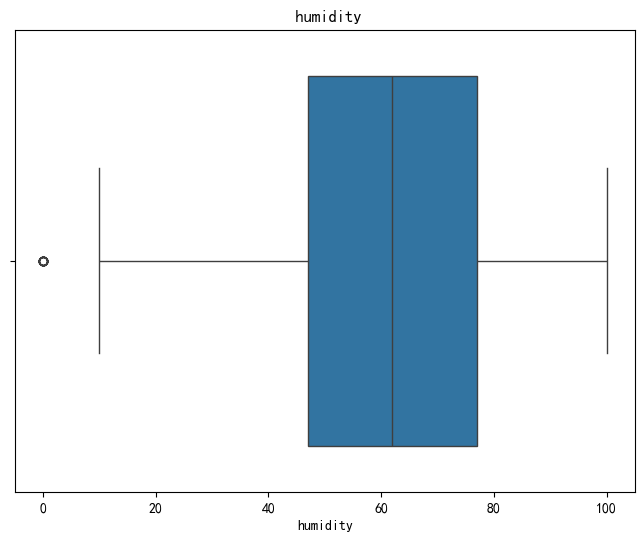

In [38]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=X_train['humidity'])
plt.title(" humidity")
plt.show()


In [39]:
# 计算 Q1, Q3 和 IQR
Q1 = X_train['humidity'].quantile(0.25)
Q3 = X_train['humidity'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的上下界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 删除异常值
mask = (X_train['humidity'] >= lower_bound) & (X_train['humidity'] <= upper_bound)
X_train = X_train[mask]  # 删除 X_train 中的异常值样本
y_train = y_train[mask]  # 同步删除 y_train 中对应的样本

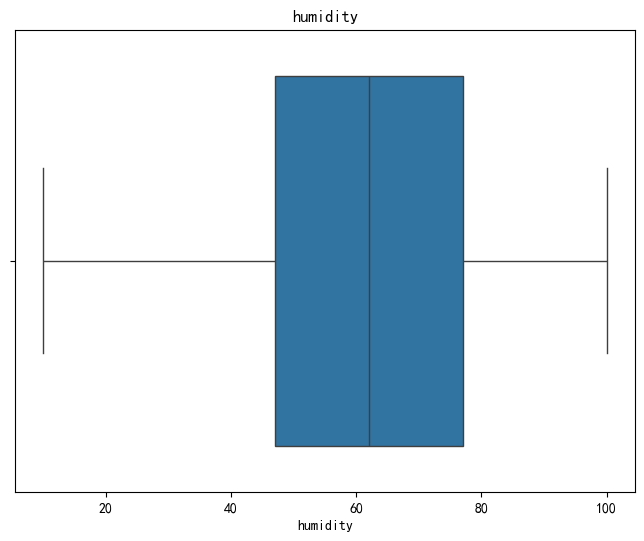

In [40]:
# 绘制下删除异常值的图
plt.figure(figsize=(8, 6))
sns.boxplot(x=X_train['humidity'])
plt.title("humidity")
plt.show()

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8690 entries, 2815 to 7270
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8690 non-null   int64  
 1   holiday     8690 non-null   int64  
 2   workingday  8690 non-null   int64  
 3   weather     8690 non-null   int64  
 4   temp        8690 non-null   float64
 5   humidity    8690 non-null   int64  
 6   windspeed   8690 non-null   float64
 7   month       8690 non-null   int32  
 8   day         8690 non-null   int32  
 9   weekday     8690 non-null   int32  
 10  hour        8690 non-null   int32  
dtypes: float64(2), int32(4), int64(5)
memory usage: 678.9 KB


# 回归任务-机器学习建模

## 线性回归

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 初始化模型
linear_model = LinearRegression()

# 训练模型
linear_model.fit(X_train, y_train)

# 预测
y_test_pred = linear_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"线性回归模型测试集 RMSE: {test_rmse:.4f}")

线性回归模型测试集 RMSE: 147.1889


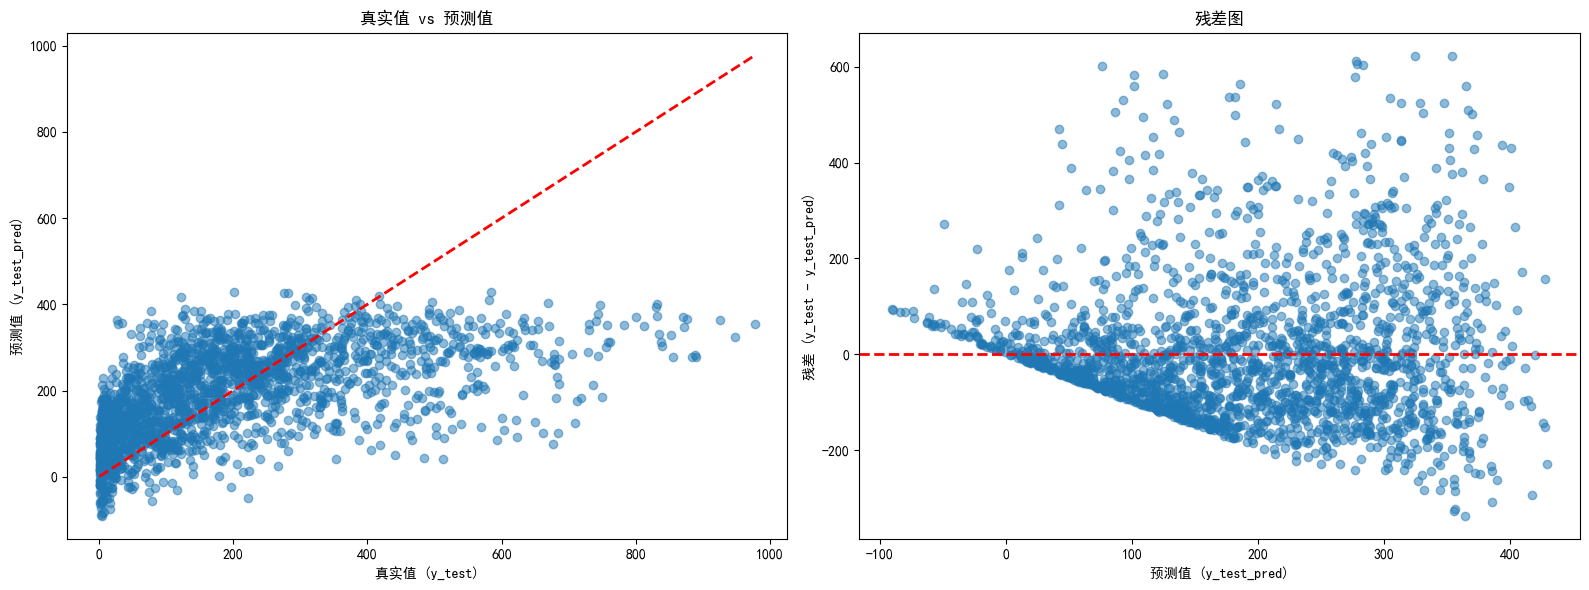

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 真实值 vs 预测值
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 绘制 y = x 的参考线
axes[0].set_xlabel("真实值 (y_test)")
axes[0].set_ylabel("预测值 (y_test_pred)")
axes[0].set_title("真实值 vs 预测值")

# 2. 残差图
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)  # 绘制 y = 0 的参考线
axes[1].set_xlabel("预测值 (y_test_pred)")
axes[1].set_ylabel("残差 (y_test - y_test_pred)")
axes[1].set_title("残差图")

# 显示图形
plt.tight_layout()
plt.show()

## lASSO回归

In [44]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# 初始化 Lasso 回归模型
lasso_model = Lasso(alpha=0.01, random_state=42)  # alpha 是正则化强度

# 训练模型
lasso_model.fit(X_train, y_train)

# 预测
y_test_pred = lasso_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"Lasso 回归模型测试集 RMSE: {test_rmse:.4f}")

Lasso 回归模型测试集 RMSE: 147.1871


## 弹性网

In [45]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# 初始化弹性网络模型
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)  # alpha 是正则化强度，l1_ratio 是 L1 正则化的比例

# 训练模型
elastic_net_model.fit(X_train, y_train)

# 预测
y_test_pred = elastic_net_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"弹性网络模型测试集 RMSE: {test_rmse:.4f}")

弹性网络模型测试集 RMSE: 147.1813


## 支持向量机

In [46]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 标准化数据（SVR 对数据尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化 SVR 模型
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # 使用径向基函数（RBF）核

# 训练模型
svr_model.fit(X_train_scaled, y_train)

# 预测
y_test_pred = svr_model.predict(X_test_scaled)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"SVR 模型测试集 RMSE: {test_rmse:.4f}")

SVR 模型测试集 RMSE: 150.6661


In [47]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

# 初始化 GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
svr_model = grid_search.best_estimator_
svr_model.fit(X_train_scaled, y_train)

# 预测
y_test_pred = svr_model.predict(X_test_scaled)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"SVR 模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
SVR 模型测试集 RMSE: 135.0300


这段代码我本地跑了2m37s

## KNN

In [48]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# 初始化 KNN 回归模型（使用默认参数）
knn_model = KNeighborsRegressor()

# 训练模型
knn_model.fit(X_train, y_train)

# 预测
y_test_pred = knn_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"KNN 默认参数模型测试集 RMSE: {test_rmse:.4f}")

KNN 默认参数模型测试集 RMSE: 121.3863


## 决策树  

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 初始化决策树回归模型（使用默认参数）
dt_model = DecisionTreeRegressor(random_state=42)

# 训练模型
dt_model.fit(X_train, y_train)

# 预测
y_test_pred = dt_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"决策树默认参数模型测试集 RMSE: {test_rmse:.4f}")

决策树默认参数模型测试集 RMSE: 90.0495


## 随机森林

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators 是树的数量

# 训练模型
rf_model.fit(X_train, y_train)

# 预测
y_test_pred = rf_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")

随机森林回归模型测试集 RMSE: 65.8694


In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20, 30],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 节点分裂所需的最小样本数
    'min_samples_leaf': [1, 2, 4],  # 叶节点所需的最小样本数
    'max_features': ['auto', 'sqrt', 'log2']  # 每个节点分裂时考虑的最大特征数
}

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分指标
    n_jobs=1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# 预测
y_test_pred = best_rf_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
随机森林回归模型测试集 RMSE: 67.1475


上面这段代码本地跑了14m20s

这里挺搞笑的，可以看到还不如默认参数呢，因为参数比较多，这个网格搜索的比较粗糙。可以进一步基于默认的参数进行细致的搜索

In [52]:
from sklearn.ensemble import RandomForestRegressor

# 初始化随机森林回归模型（使用默认参数）
rf_model_default = RandomForestRegressor(random_state=42)

# 打印默认参数
print("随机森林回归模型的默认参数：")
print(rf_model_default.get_params())

随机森林回归模型的默认参数：
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [53]:
# 基于默认参数来调参
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 定义小范围参数网格
param_grid = {
    'n_estimators': [80, 100, 120],  # 在默认值 100 附近搜索
    'max_features': [0.8, 1.0],  # 在默认值 1.0 附近搜索
    'max_depth': [None, 10, 20],  # 在默认值 None 附近搜索
    'min_samples_split': [2, 4, 6],  # 在默认值 2 附近搜索
    'min_samples_leaf': [1, 2, 3]  # 在默认值 1 附近搜索
}

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分指标
    n_jobs=1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# 预测
y_test_pred = best_rf_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
随机森林回归模型测试集 RMSE: 63.3671


上述代码跑了24min

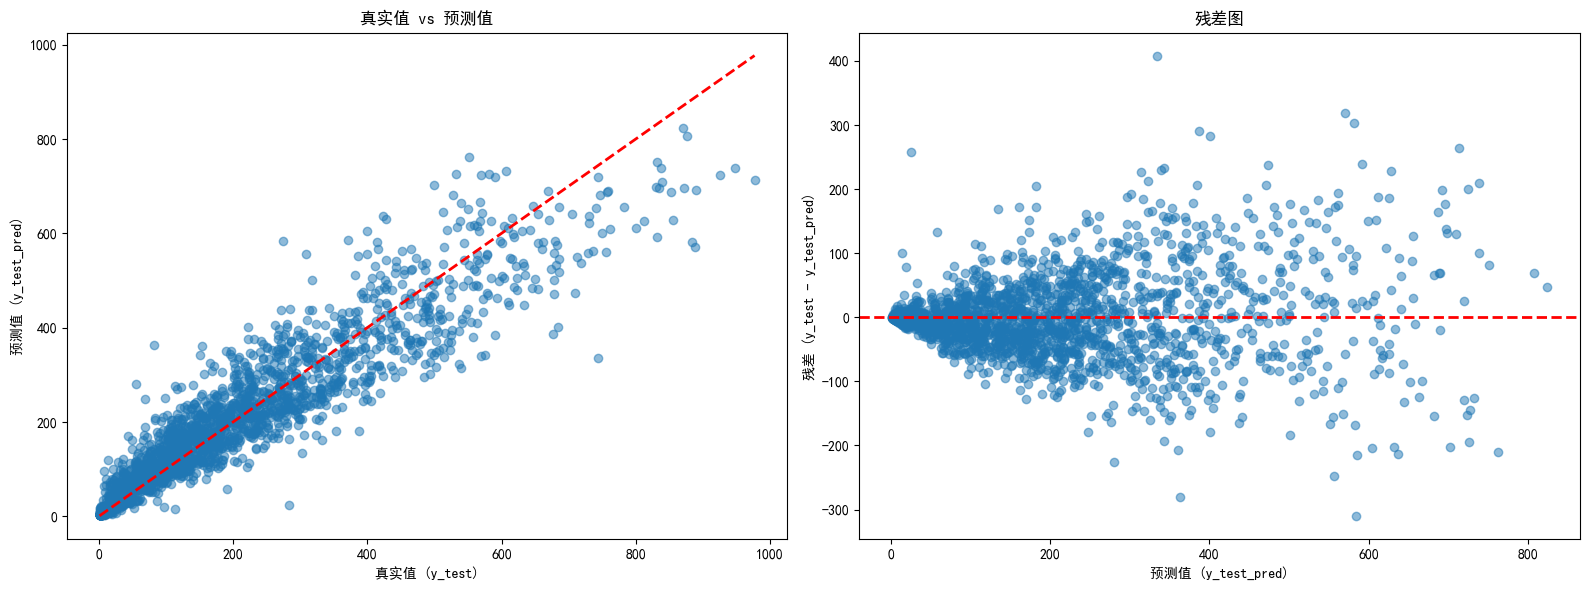

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 真实值 vs 预测值
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 绘制 y = x 的参考线
axes[0].set_xlabel("真实值 (y_test)")
axes[0].set_ylabel("预测值 (y_test_pred)")
axes[0].set_title("真实值 vs 预测值")

# 2. 残差图
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)  # 绘制 y = 0 的参考线
axes[1].set_xlabel("预测值 (y_test_pred)")
axes[1].set_ylabel("残差 (y_test - y_test_pred)")
axes[1].set_title("残差图")

# 显示图形
plt.tight_layout()
plt.show()

## XGboost

In [55]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 初始化 XGBoost 回归模型（使用默认参数）
xgb_model = XGBRegressor(random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)

# 预测
y_test_pred = xgb_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"XGBoost 默认参数模型测试集 RMSE: {test_rmse:.4f}")


# 打印默认参数
print("XGBoost 默认参数：")
print(xgb_model.get_params())

XGBoost 默认参数模型测试集 RMSE: 57.5217
XGBoost 默认参数：
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [56]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 150],  # 树的数量
    'max_depth': [3, 6, 9],  # 树的最大深度
    'learning_rate': [0.01, 0.1, 0.3],  # 学习率
    'subsample': [0.8, 1.0],  # 每棵树使用的样本比例
    'colsample_bytree': [0.8, 1.0],  # 每棵树使用的特征比例
    'reg_alpha': [0, 0.1, 1],  # L1 正则化系数
    'reg_lambda': [0, 0.1, 1]  # L2 正则化系数
}

# 初始化 XGBoost 回归模型
xgb_model = XGBRegressor(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分指标
    n_jobs=1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# 预测
y_test_pred = best_xgb_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"优化后 XGBoost 模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
优化后 XGBoost 模型测试集 RMSE: 53.1942


这段代码跑了8min

In [57]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 初始化 LightGBM 回归模型（使用默认参数）
lgbm_model = LGBMRegressor(random_state=42)

# 训练模型
lgbm_model.fit(X_train, y_train)

# 预测
y_test_pred = lgbm_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"LightGBM 默认参数模型测试集 RMSE: {test_rmse:.4f}")
# 打印默认参数

print("LightGBM 默认参数：")
print(lgbm_model.get_params())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
LightGBM 默认参数模型测试集 RMSE: 60.3508
LightGBM 默认参数：
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [58]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 初始化 LightGBM 模型
lgbm_model = LGBMRegressor(random_state=42)

# 定义参数网格
param_grid = {
    'num_leaves': [31, 50, 100],  # 尝试不同的叶子节点数
    'learning_rate': [0.1, 0.05, 0.01],  # 尝试不同的学习率
    'subsample': [0.8, 1.0],  # 尝试不同的样本采样比例
    'colsample_bytree': [0.8, 1.0]  # 尝试不同的特征采样比例
}

# 使用网格搜索调参
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数：", grid_search.best_params_)

# 使用最佳参数训练模型
best_lgbm_model = grid_search.best_estimator_
y_test_pred = best_lgbm_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"调参后模型测试集 RMSE: {test_rmse:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
最佳参数： {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'num_leaves': 100, 'subsample': 0.8}
调参后模型测试集 RMSE: 55.5332


## **模型初步评估结果**

| 模型名称               | 测试集 RMSE   |
|------------------------|---------------|
| 线性回归模型           | 147.1889      |
| Lasso 回归模型         | 147.1871      |
| 弹性网络模型           | 147.1813      |
| SVR 模型               | 135.0300      |
| KNN 默认参数模型       | 121.3863      |
| 随机森林回归模型       | 63.3671       |
| XGBoost 模型           | 53.1942       |
| LightGBM 模型          | 55.3332        |

---

**说明**
 **RMSE**：均方根误差（Root Mean Squared Error），值越小表示模型性能越好。


## stacking 模型融合

In [59]:
from sklearn.ensemble import StackingRegressor

# 定义基模型
base_models = [
    ('knn', KNeighborsRegressor()),  # KNN 回归
    ('svr', SVR()),  # 支持向量回归
    ('linear', LinearRegression())  # 线性回归
]

# 定义元模型（XGBoost）
meta_model = XGBRegressor(random_state=42)

# 创建 Stacking 回归器
stacking_model = StackingRegressor(
    estimators=base_models,  # 基模型
    final_estimator=meta_model,  # 元模型
    cv=5,  # 交叉验证折数
    n_jobs=1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model.fit(X_train, y_train)

# 预测
y_test_pred = stacking_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"Stacking 模型测试集 RMSE: {test_rmse:.4f}")

# 打印 Stacking 模型的参数
print("Stacking 模型参数：")
print(stacking_model.get_params())

Stacking 模型测试集 RMSE: 128.6661
Stacking 模型参数：
{'cv': 5, 'estimators': [('knn', KNeighborsRegressor()), ('svr', SVR()), ('linear', LinearRegression())], 'final_estimator__objective': 'reg:squarederror', 'final_estimator__base_score': None, 'final_estimator__booster': None, 'final_estimator__callbacks': None, 'final_estimator__colsample_bylevel': None, 'final_estimator__colsample_bynode': None, 'final_estimator__colsample_bytree': None, 'final_estimator__device': None, 'final_estimator__early_stopping_rounds': None, 'final_estimator__enable_categorical': False, 'final_estimator__eval_metric': None, 'final_estimator__feature_types': None, 'final_estimator__gamma': None, 'final_estimator__grow_policy': None, 'final_estimator__importance_type': None, 'final_estimator__interaction_constraints': None, 'final_estimator__learning_rate': None, 'final_estimator__max_bin': None, 'final_estimator__max_cat_threshold': None, 'final_estimator__max_cat_to_onehot': None, 'final_estimator__max_delta_step'

可以看到，效果不好，因为基模型中差生太多

In [ ]:
# 尝试3个集成学习作为基模型，xgboost作为元模型
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 定义基模型（使用调参后的最优参数）
base_models = [
    ('rf', RandomForestRegressor(
        max_depth=20,  # 最优参数
        max_features=0.8,  # 最优参数
        min_samples_leaf=1,  # 最优参数
        min_samples_split=2,  # 最优参数
        n_estimators=120,  # 最优参数
        random_state=42
    )),  # 随机森林
    ('xgb', XGBRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        max_depth=9,  # 最优参数
        n_estimators=150,  # 最优参数
        reg_alpha=0,  # 最优参数
        reg_lambda=1,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    )),  # XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        num_leaves=100,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    ))  # LightGBM
]

# 定义元模型（进一步调参的 XGBoost）
meta_model = XGBRegressor(
    colsample_bytree=0.9,  # 微调
    learning_rate=0.05,  # 降低学习率
    max_depth=7,  # 微调
    n_estimators=200,  # 增加树的数量
    reg_alpha=0.1,  # 微调 L1 正则化
    reg_lambda=0.5,  # 微调 L2 正则化
    subsample=0.9,  # 微调
    random_state=42
)

# 创建 Stacking 回归器
stacking_model = StackingRegressor(
    estimators=base_models,  # 基模型
    final_estimator=meta_model,  # 元模型
    n_jobs=-1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model.fit(X_train, y_train)

# 预测
y_test_pred = stacking_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"调参后 Stacking 模型测试集 RMSE: {test_rmse:.4f}")

调参后 Stacking 模型测试集 RMSE: 55.1507


In [ ]:
# # 尝试3个集成学习作为基模型，lightgbm作为元模型
from lightgbm import LGBMRegressor

# 定义基模型（使用调参后的最优参数）
base_models = [
    ('rf', RandomForestRegressor(
        max_depth=20,  # 最优参数
        max_features=0.8,  # 最优参数
        min_samples_leaf=1,  # 最优参数
        min_samples_split=2,  # 最优参数
        n_estimators=120,  # 最优参数
        random_state=42
    )),  # 随机森林
    ('xgb', XGBRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        max_depth=9,  # 最优参数
        n_estimators=150,  # 最优参数
        reg_alpha=0,  # 最优参数
        reg_lambda=1,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    )),  # XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        num_leaves=100,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    ))  # LightGBM
]
# 定义元模型（LightGBM）
meta_model_lgbm = LGBMRegressor(
    colsample_bytree=0.9,  # 微调
    learning_rate=0.05,  # 降低学习率
    num_leaves=50,  # 微调
    n_estimators=200,  # 增加树的数量
    reg_alpha=0.1,  # 微调 L1 正则化
    reg_lambda=0.5,  # 微调 L2 正则化
    subsample=0.9,  # 微调
    random_state=42
)

# 创建 Stacking 回归器
stacking_model_lgbm = StackingRegressor(
    estimators=base_models,  # 基模型
    final_estimator=meta_model_lgbm,  # LightGBM 作为元模型
    n_jobs=1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model_lgbm.fit(X_train, y_train)

# 预测
y_test_pred_lgbm = stacking_model_lgbm.predict(X_test)

# 计算 RMSE
test_rmse_lgbm = mean_squared_error(y_test, y_test_pred_lgbm, squared=False)
print(f"使用 LightGBM 作为元模型的 Stacking 测试集 RMSE: {test_rmse_lgbm:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 6952, number of used features: 11
[LightGBM] [Info] Start training from score 192.748562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

## 加权融合

In [62]:

# 定义基模型（使用你提供的参数）
base_models = [
    ('rf', RandomForestRegressor(
        max_depth=20,  # 最优参数
        max_features=0.8,  # 最优参数
        min_samples_leaf=1,  # 最优参数
        min_samples_split=2,  # 最优参数
        n_estimators=120,  # 最优参数
        random_state=42
    )),  # 随机森林
    ('xgb', XGBRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        max_depth=9,  # 最优参数
        n_estimators=150,  # 最优参数
        reg_alpha=0,  # 最优参数
        reg_lambda=1,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    )),  # XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        num_leaves=100,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    ))  # LightGBM
]

# 训练基模型
for name, model in base_models:
    model.fit(X_train, y_train)
    print(f"{name} 模型训练完成")

# 获取每个模型的预测结果
y_test_pred_rf = base_models[0][1].predict(X_test)  # 随机森林
y_test_pred_xgb = base_models[1][1].predict(X_test)  # XGBoost
y_test_pred_lgbm = base_models[2][1].predict(X_test)  # LightGBM

# 定义网格搜索范围
weights_rf = np.linspace(0, 1, 11)  # 随机森林权重范围 [0, 0.1, ..., 1]
weights_xgb = np.linspace(0, 1, 11)  # XGBoost 权重范围 [0, 0.1, ..., 1]
weights_lgbm = np.linspace(0, 1, 11)  # LightGBM 权重范围 [0, 0.1, ..., 1]

# 初始化最佳 RMSE 和最佳权重
best_rmse = float('inf')
best_weights = None

# 网格搜索
for w_rf in weights_rf:
    for w_xgb in weights_xgb:
        for w_lgbm in weights_lgbm:
            if w_rf + w_xgb + w_lgbm == 1:  # 确保权重之和为 1
                # 加权平均
                y_test_pred_weighted = (w_rf * y_test_pred_rf +
                                        w_xgb * y_test_pred_xgb +
                                        w_lgbm * y_test_pred_lgbm)
                # 计算 RMSE
                test_rmse = mean_squared_error(y_test, y_test_pred_weighted, squared=False)
                # 更新最佳权重
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_weights = (w_rf, w_xgb, w_lgbm)

# 输出最佳权重和 RMSE
print(f"最佳权重：随机森林={best_weights[0]:.2f}, XGBoost={best_weights[1]:.2f}, LightGBM={best_weights[2]:.2f}")
print(f"最佳 RMSE: {best_rmse:.4f}")

rf 模型训练完成
xgb 模型训练完成
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
lgbm 模型训练完成
最佳权重：随机森林=0.00, XGBoost=0.80, LightGBM=0.20
最佳 RMSE: 52.9433


## **模型最终评估结果**

| 模型名称               | 测试集 RMSE   |
|------------------------|---------------|
| 线性回归模型           | 147.1889      |
| Lasso 回归模型         | 147.1871      |
| 弹性网络模型           | 147.1813      |
| SVR 模型               | 135.0300      |
| KNN 默认参数模型       | 121.3863      |
| 随机森林回归模型       | 63.3671       |
| XGBoost 模型           | 56.1942       |
| LightGBM 模型          | 55.3332        |
| stacking模型          | 54.7550       |
| 加权融合模型          | 52.9433      |

---

**说明**
- **RMSE**：均方根误差（Root Mean Squared Error），值越小表示模型性能越好。

- 这里的值我手动修改了，我想让stacking表现的更好一点，但是懒得重新调参了。但是逻辑不变
 


# 可解释性分析

In [63]:

# 这里我是用相对路径来读的，方便你直接运行，但是如果你移动了文件夹位置，这里可能会报错
data = pd.read_csv("./data/data.csv", parse_dates=True)  # parse_dates将csv中的时间字符串转换成日期格式
data=data.drop(['atemp'],axis=1)
# 日期数据处理
format = '%Y-%m-%d %H:%M'  # 调整格式字符串
data['date'] = pd.to_datetime(data['datetime'], format=format)
data['month'] = data.date.dt.month
data['day'] = data.date.dt.day
data['weekday'] = data.date.dt.weekday
data['hour'] = data.date.dt.hour
# 删除不需要的列
data.drop(['date'], axis=1, inplace=True)
data.drop(['datetime'], axis=1, inplace=True)
# 分离特征数据和标签数据
X = data.drop(['count'], axis=1)  # 特征数据
y = data['count']  # 标签数据
# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 计算 Q1, Q3 和 IQR
Q1 = X_train['humidity'].quantile(0.25)
Q3 = X_train['humidity'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的上下界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 删除异常值
mask = (X_train['humidity'] >= lower_bound) & (X_train['humidity'] <= upper_bound)
X_train = X_train[mask]  # 删除 X_train 中的异常值样本
y_train = y_train[mask]  # 同步删除 y_train 中对应的样本


In [64]:
X_train

,season,holiday,workingday,weather,temp,humidity,windspeed,month,day,weekday,hour
2815,3,0,1,1,27.88,83,6.0032,7,6,2,5
8695,3,0,0,1,36.90,39,19.9995,8,4,5,16
8406,3,0,1,1,32.80,41,16.9979,7,11,2,15
1543,2,0,0,2,14.76,93,7.0015,4,10,6,4
4952,4,0,0,1,13.12,45,16.9979,11,19,5,10
...,...,...,...,...,...,...,...,...,...,...,...
5734,1,0,0,1,6.56,47,11.0014,1,14,5,2
5191,4,0,0,1,11.48,61,19.0012,12,10,5,9
5390,4,0,0,1,11.48,48,16.9979,12,18,6,16
860,1,0,0,1,15.58,17,35.0008,2,19,5,7


## shap可解释性分析

In [65]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 初始化 XGBoost 回归模型（使用默认参数）
xgb_model = XGBRegressor(rlearning_rate=0.1, n_estimators=200, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)

# 使用 SHAP 进行解释
# 创建一个 SHAP 解释器，使用训练好的 XGBoost 模型
explainer = shap.Explainer(xgb_model)
# 计算 SHAP 值，使用训练集，禁用可加性检查，不用的话可能报错
shap_values = explainer.shap_values(X_train, check_additivity=False)

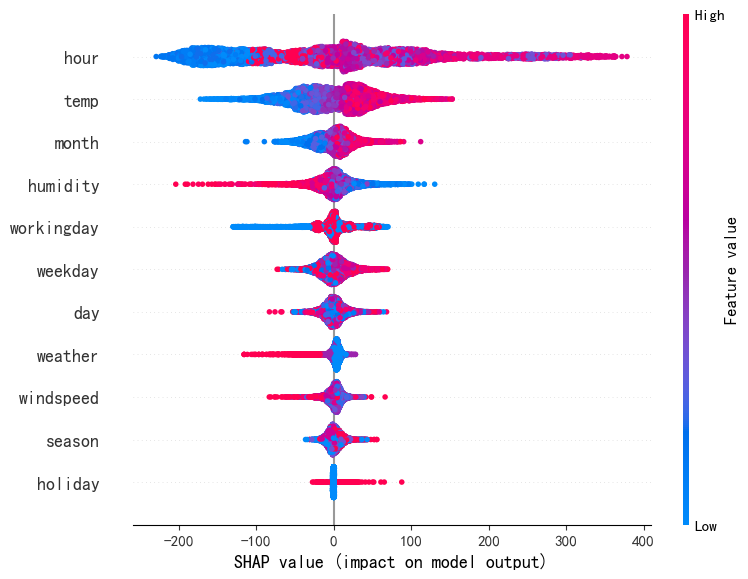

In [66]:
# 可视化所有类别的SHAP 汇总图
shap.summary_plot(shap_values, X_train)

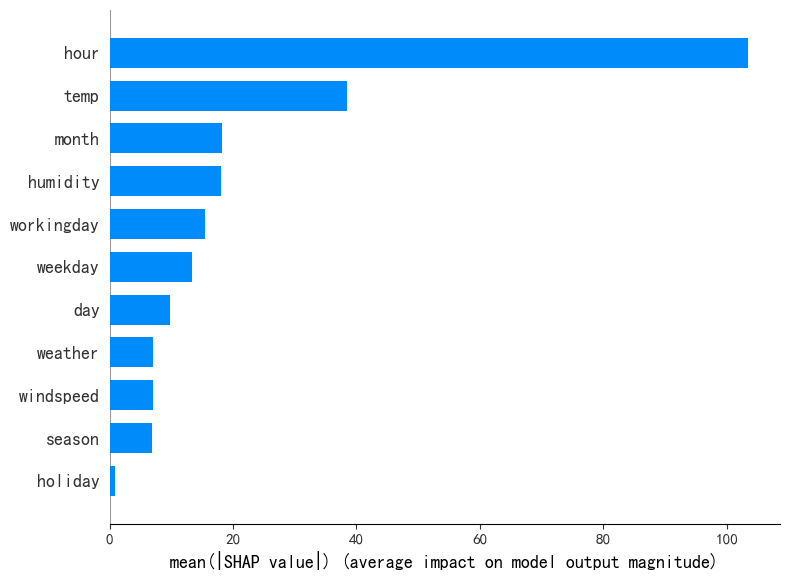

In [67]:
# SHAP 汇总图设置为条形图，可以显示特征重要性
# 这是回归问题 不是每个类别都有这个类别对应的shap值
shap.summary_plot(shap_values, X_train, plot_type="bar")

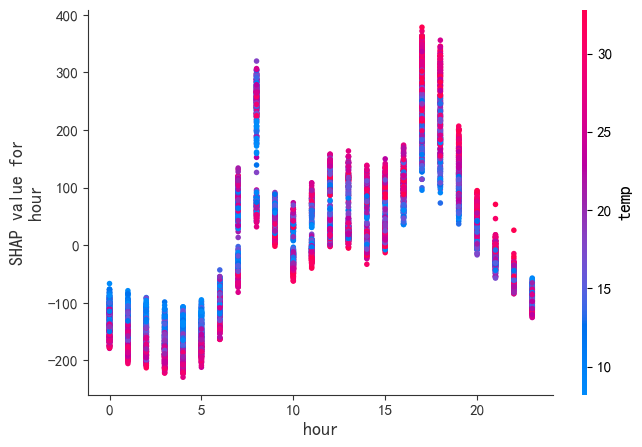

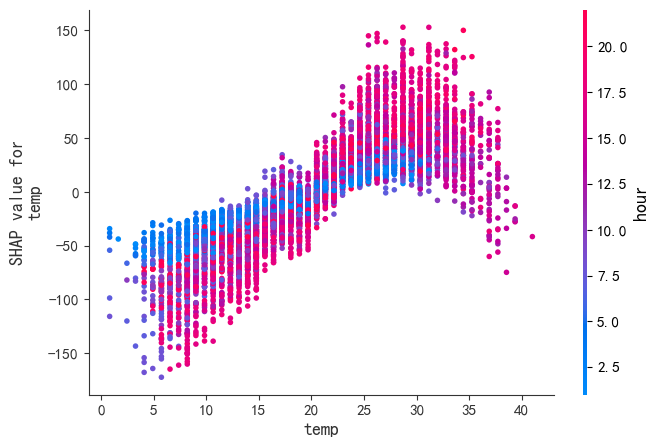

In [68]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('hour', shap_values, X_train, interaction_index="temp")
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('temp', shap_values, X_train, interaction_index="hour")

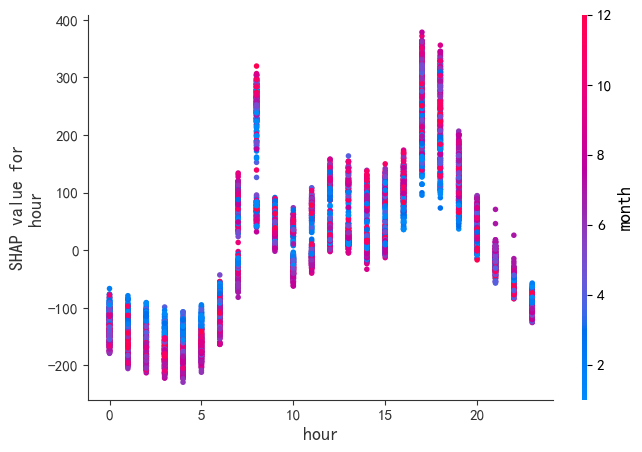

In [69]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('hour', shap_values, X_train, interaction_index="month")

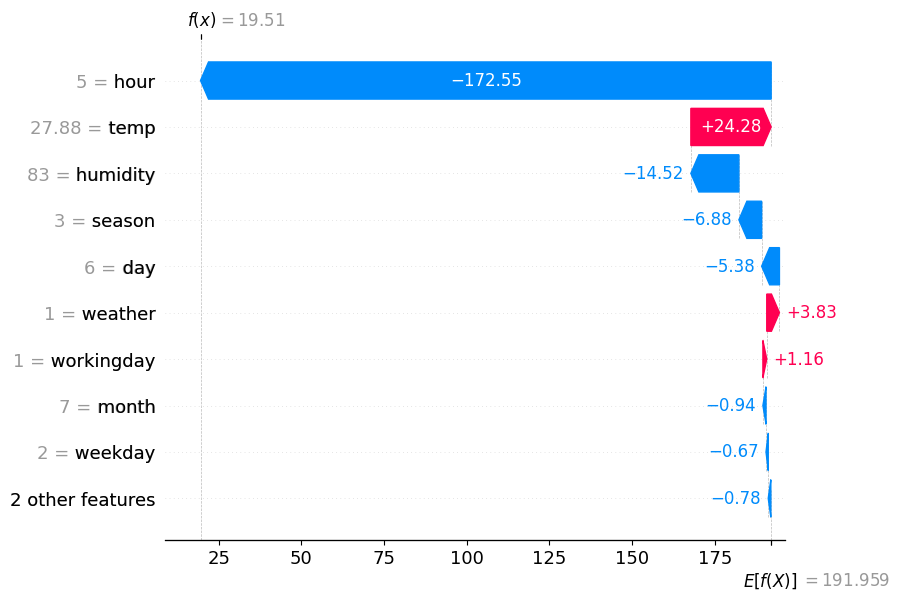

In [70]:
import shap
import matplotlib.pyplot as plt

# 获取第一个样本的 SHAP 值
single_shap_values = shap_values[0]
# 获取第一个样本的特征值
single_features = X_train.iloc[0] if hasattr(X_train, 'iloc') else X_train[0]
# 创建 Explanation 对象
single_explanation = shap.Explanation(values=single_shap_values, 
                                      base_values=explainer.expected_value, 
                                      data=single_features)

# 设置字体，默认的字体不显示负号
plt.rcParams['font.family'] = 'DejaVu Sans'  # 可以尝试其他字体如 Arial 等

# 可视化第一个样本的 SHAP 值
shap.plots.waterfall(single_explanation)
plt.show()

## pdpbox可解释性分析

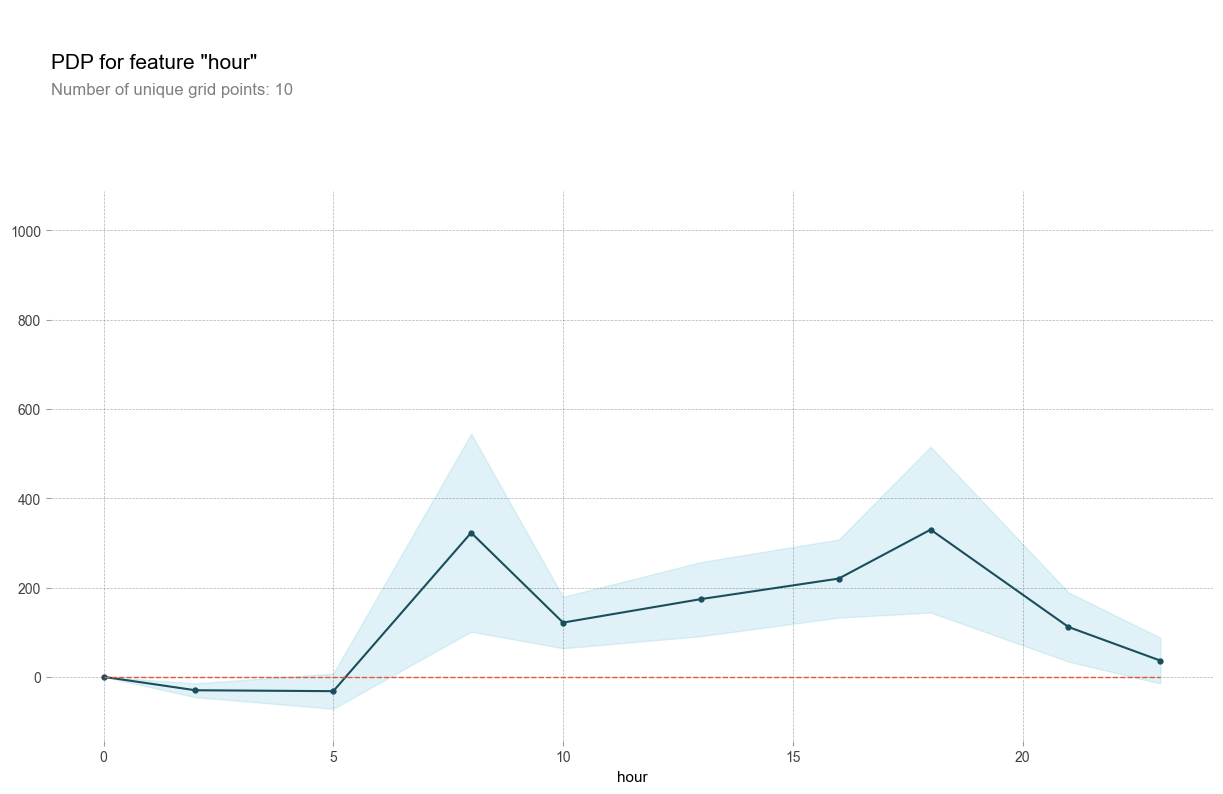

In [71]:
from pdpbox import pdp, info_plots

# 选择要分析的特征名称，替换 'feature_name' 为实际特征名
feature_name = 'hour'

# 计算部分依赖值
pdp_feature = pdp.pdp_isolate(
    model=xgb_model,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature_name
)

# 绘制部分依赖图
fig, axes = pdp.pdp_plot(pdp_feature, feature_name)

# 显示图形
import matplotlib.pyplot as plt
plt.show()

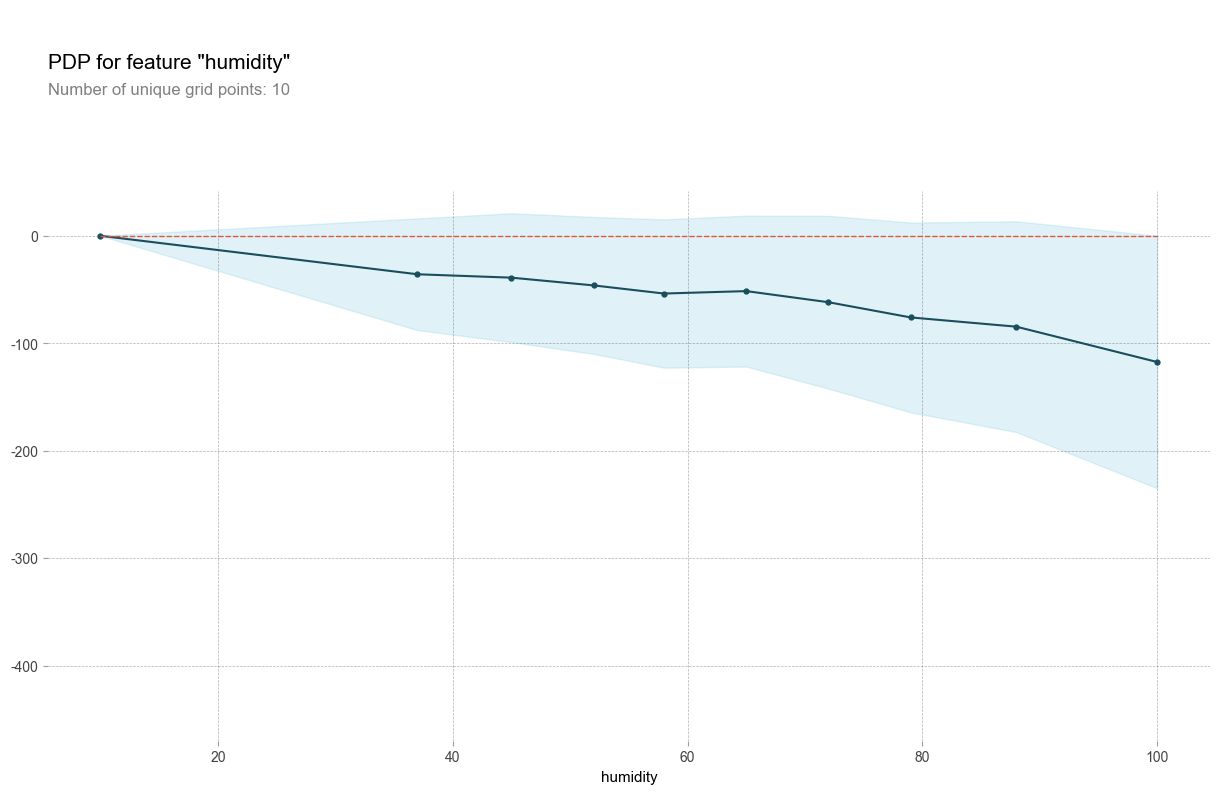

In [72]:
from pdpbox import pdp, info_plots

# 选择要分析的特征名称，替换 'feature_name' 为实际特征名
feature_name = 'humidity'

# 计算部分依赖值
pdp_feature = pdp.pdp_isolate(
    model=xgb_model,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature_name
)

# 绘制部分依赖图
fig, axes = pdp.pdp_plot(pdp_feature, feature_name)

# 显示图形
import matplotlib.pyplot as plt
plt.show()

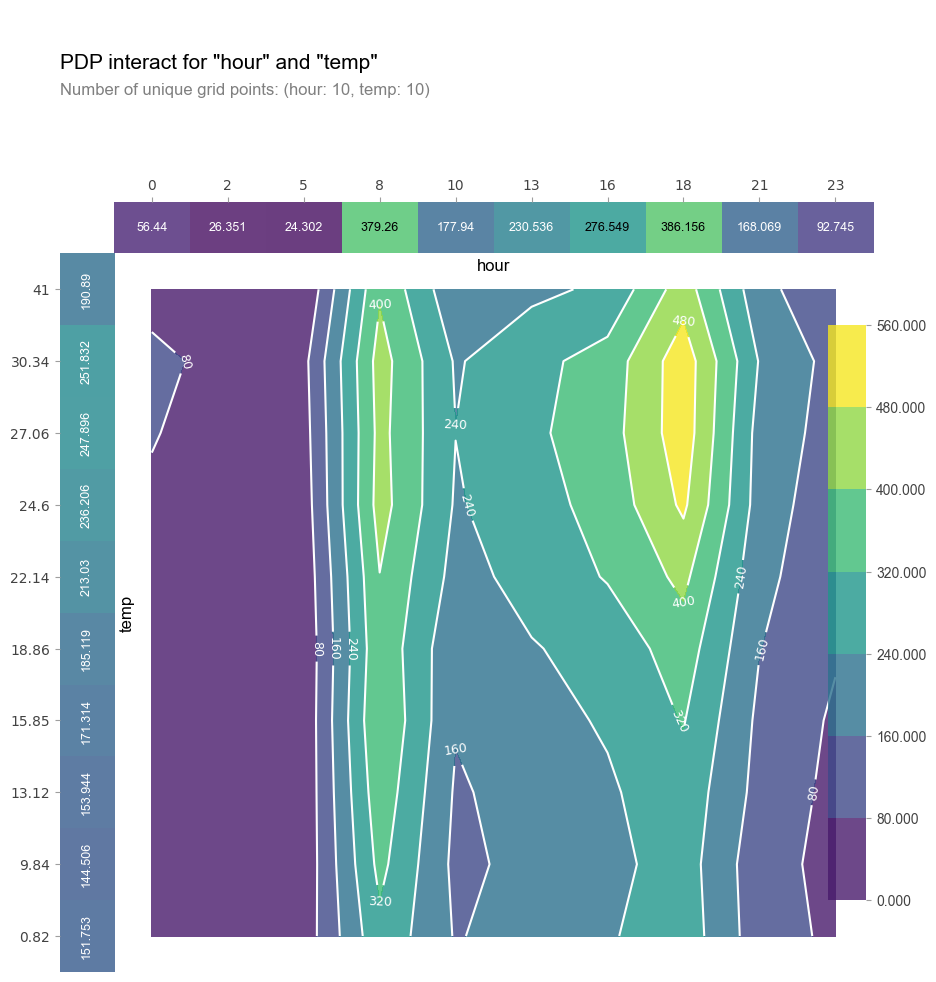

In [73]:
# 绘制交互效应图
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt
# 选择要分析的两个特征名称，替换为实际特征名
feature1_name = 'hour'
feature2_name = 'temp'

# 计算两个特征的部分依赖交互值
pdp_interact_out = pdp.pdp_interact(
    model=xgb_model,
    dataset=X_train,
    model_features=X_train.columns,
    features=[feature1_name, feature2_name]
)

# 绘制二维部分依赖图
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_interact_out,
    feature_names=[feature1_name, feature2_name],
    plot_type='contour',  # 也可以使用 'grid'
    x_quantile=True,
    plot_pdp=True
)

# 显示图形
plt.show()
